In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [2]:
dataset = pd.read_csv("/kaggle/input/breast-cancer-dataset/breast-cancer.csv")
dataset.drop(columns=['id'],inplace = True)

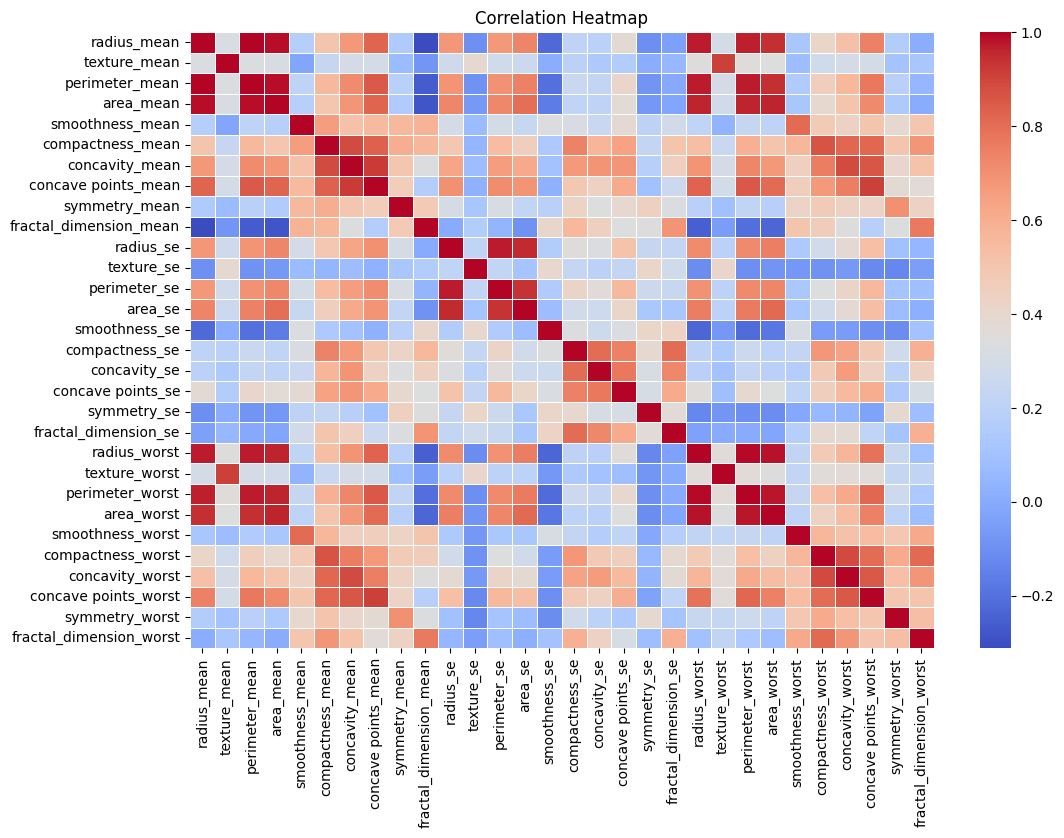

In [3]:
correlation_matrix = dataset.drop(columns=['diagnosis']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [13]:
X = dataset.drop(columns=['diagnosis'])
y = dataset['diagnosis']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 'M' -> 1, 'B' -> 0
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_neighbors': range(1, 16),
    'metric': ['euclidean', 'manhattan', 'cosine']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best K determined by GridSearchCV: {best_k}\n")
print(f"Best dist determined by GridSearchCV: {grid_search.best_params_['metric']}\n")

performance_metrics = {}

for metric in ['euclidean', 'manhattan', 'cosine']:
    # Train a KNN model with the best K and the current distance metric
    knn = KNeighborsClassifier(n_neighbors=best_k, metric=metric)
    knn.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = knn.predict(X_test)
    y_proba = knn.predict_proba(X_test)[:, 1]
    
    # Calculate evaluation metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    performance_metrics[metric] = {
        'accuracy': report['accuracy'],
        'precision': report['1']['precision'],  # For class '1' (Malignant)
        'recall': report['1']['recall'],
        'f1_score': report['1']['f1-score'],
        'roc_auc': roc_auc
    }

    # Print the results for the current metric
    print(f"Performance with {metric.capitalize()} distance (K={best_k}):")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc)
    print()

# Summarize the performance metrics for comparison
print("\nSummary of Performance Metrics:")
summary_df = pd.DataFrame(performance_metrics).T
print(summary_df)


Best K determined by GridSearchCV: 13

Best dist determined by GridSearchCV: euclidean

Performance with Euclidean distance (K=13):
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

ROC-AUC: 0.9923026531280708

Performance with Manhattan distance (K=13):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

ROC-AUC: 0.9957418932197838

Performance with Cosine distance (K=13):
              precision    recall  f1-score   support

           0    

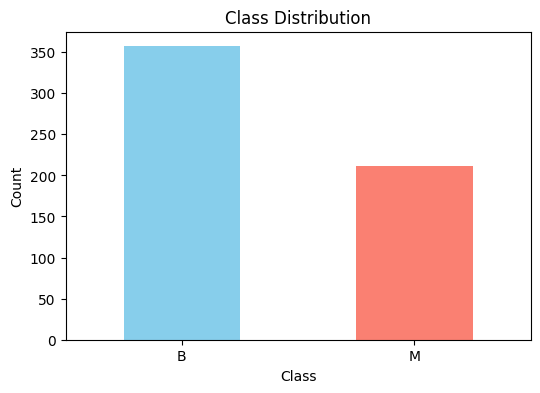

In [4]:
class_counts = dataset['diagnosis'].value_counts()

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


In [12]:
X = dataset.drop(columns=['diagnosis'])
y = dataset['diagnosis']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 'M' -> 1, 'B' -> 0
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_metrics = {}

regularization_types = ['l1', 'l2']
for reg_type in regularization_types:
    logistic_model = LogisticRegression(penalty=reg_type, solver='liblinear', random_state=42)
    
    logistic_model.fit(X_train, y_train)
    
    y_pred = logistic_model.predict(X_test)
    y_proba = logistic_model.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    logistic_metrics[reg_type] = {
        'accuracy': report['accuracy'],
        'precision': report['1']['precision'],  # For class '1' (Malignant)
        'recall': report['1']['recall'],
        'f1_score': report['1']['f1-score'],
        'roc_auc': roc_auc
    }

    print(f"Performance with {reg_type.upper()} regularization:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc)
    print()

print("\nSummary of Logistic Regression Performance:")
summary_logistic_df = pd.DataFrame(logistic_metrics).T
print(summary_logistic_df)


Performance with L1 regularization:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC-AUC: 0.9967245332459875

Performance with L2 regularization:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC-AUC: 0.99737962659679


Summary of Logistic Regression Performance:
    accuracy  precision    recall  f1_score   roc_auc
l1  0.973684   0.954545  0.976744  0.965517  0.996725
l2  0.973684   0.976190  0.953488  0.964706  0.997380


In [21]:
X = dataset.drop(columns=['diagnosis'])
y = dataset['diagnosis']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 'M' -> 1, 'B' -> 0
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm_metrics = {}

kernels = ['linear', 'poly', 'rbf']

for kernel in kernels:
    svm_model = SVC(kernel=kernel, random_state=42, probability=True)
    
    svm_model.fit(X_train, y_train)
    
    y_pred = svm_model.predict(X_test)
    y_proba = svm_model.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    svm_metrics[kernel] = {
        'accuracy': report['accuracy'],
        'precision': report['1']['precision'],  # For class '1' (Malignant)
        'recall': report['1']['recall'],
        'f1_score': report['1']['f1-score'],
        'roc_auc': roc_auc
    }

    print(f"Performance with {kernel.capitalize()} kernel:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc)
    print()

print("\nSummary of SVM Performance:")
summary_svm_df = pd.DataFrame(svm_metrics).T
print(summary_svm_df)


Performance with Linear kernel:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

ROC-AUC: 0.9963969865705863

Performance with Poly kernel:
              precision    recall  f1-score   support

           0       0.83      1.00      0.90        71
           1       1.00      0.65      0.79        43

    accuracy                           0.87       114
   macro avg       0.91      0.83      0.85       114
weighted avg       0.89      0.87      0.86       114

ROC-AUC: 0.9963969865705863

Performance with Rbf kernel:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                     

In [23]:
X = dataset.drop(columns=['diagnosis'])
y = dataset['diagnosis']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 'M' -> 1, 'B' -> 0
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ensemble_metrics = {}

# 1. Boosting: AdaBoost
adaboost_model = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost_model.fit(X_train, y_train)

y_pred_adaboost = adaboost_model.predict(X_test)
y_proba_adaboost = adaboost_model.predict_proba(X_test)[:, 1]

roc_auc_adaboost = roc_auc_score(y_test, y_proba_adaboost)
report_adaboost = classification_report(y_test, y_pred_adaboost, output_dict=True)
ensemble_metrics['AdaBoost'] = {
    'accuracy': report_adaboost['accuracy'],
    'precision': report_adaboost['1']['precision'],  # For class '1' (Malignant)
    'recall': report_adaboost['1']['recall'],
    'f1_score': report_adaboost['1']['f1-score'],
    'roc_auc': roc_auc_adaboost
}

print("AdaBoost Performance:")
print(classification_report(y_test, y_pred_adaboost))
print("ROC-AUC:", roc_auc_adaboost)
print()

# 2. Bagging: Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

y_pred_rf = random_forest_model.predict(X_test)
y_proba_rf = random_forest_model.predict_proba(X_test)[:, 1]

roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
ensemble_metrics['Random Forest'] = {
    'accuracy': report_rf['accuracy'],
    'precision': report_rf['1']['precision'],  # For class '1' (Malignant)
    'recall': report_rf['1']['recall'],
    'f1_score': report_rf['1']['f1-score'],
    'roc_auc': roc_auc_rf
}

print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_rf)
print()


print("\nSummary of Ensemble Methods Performance:")
summary_ensemble_df = pd.DataFrame(ensemble_metrics).T
print(summary_ensemble_df)


AdaBoost Performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC-AUC: 0.9970520799213888

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

ROC-AUC: 0.995250573206682


Summary of Ensemble Methods Performance:
               accuracy  precision    recall  f1_score   roc_auc
AdaBoost       0.973684    0.97619  0.953488  0.964706  0.997052
Random Forest  0.964912    0.97561  0.930233  0.952381  0.995251


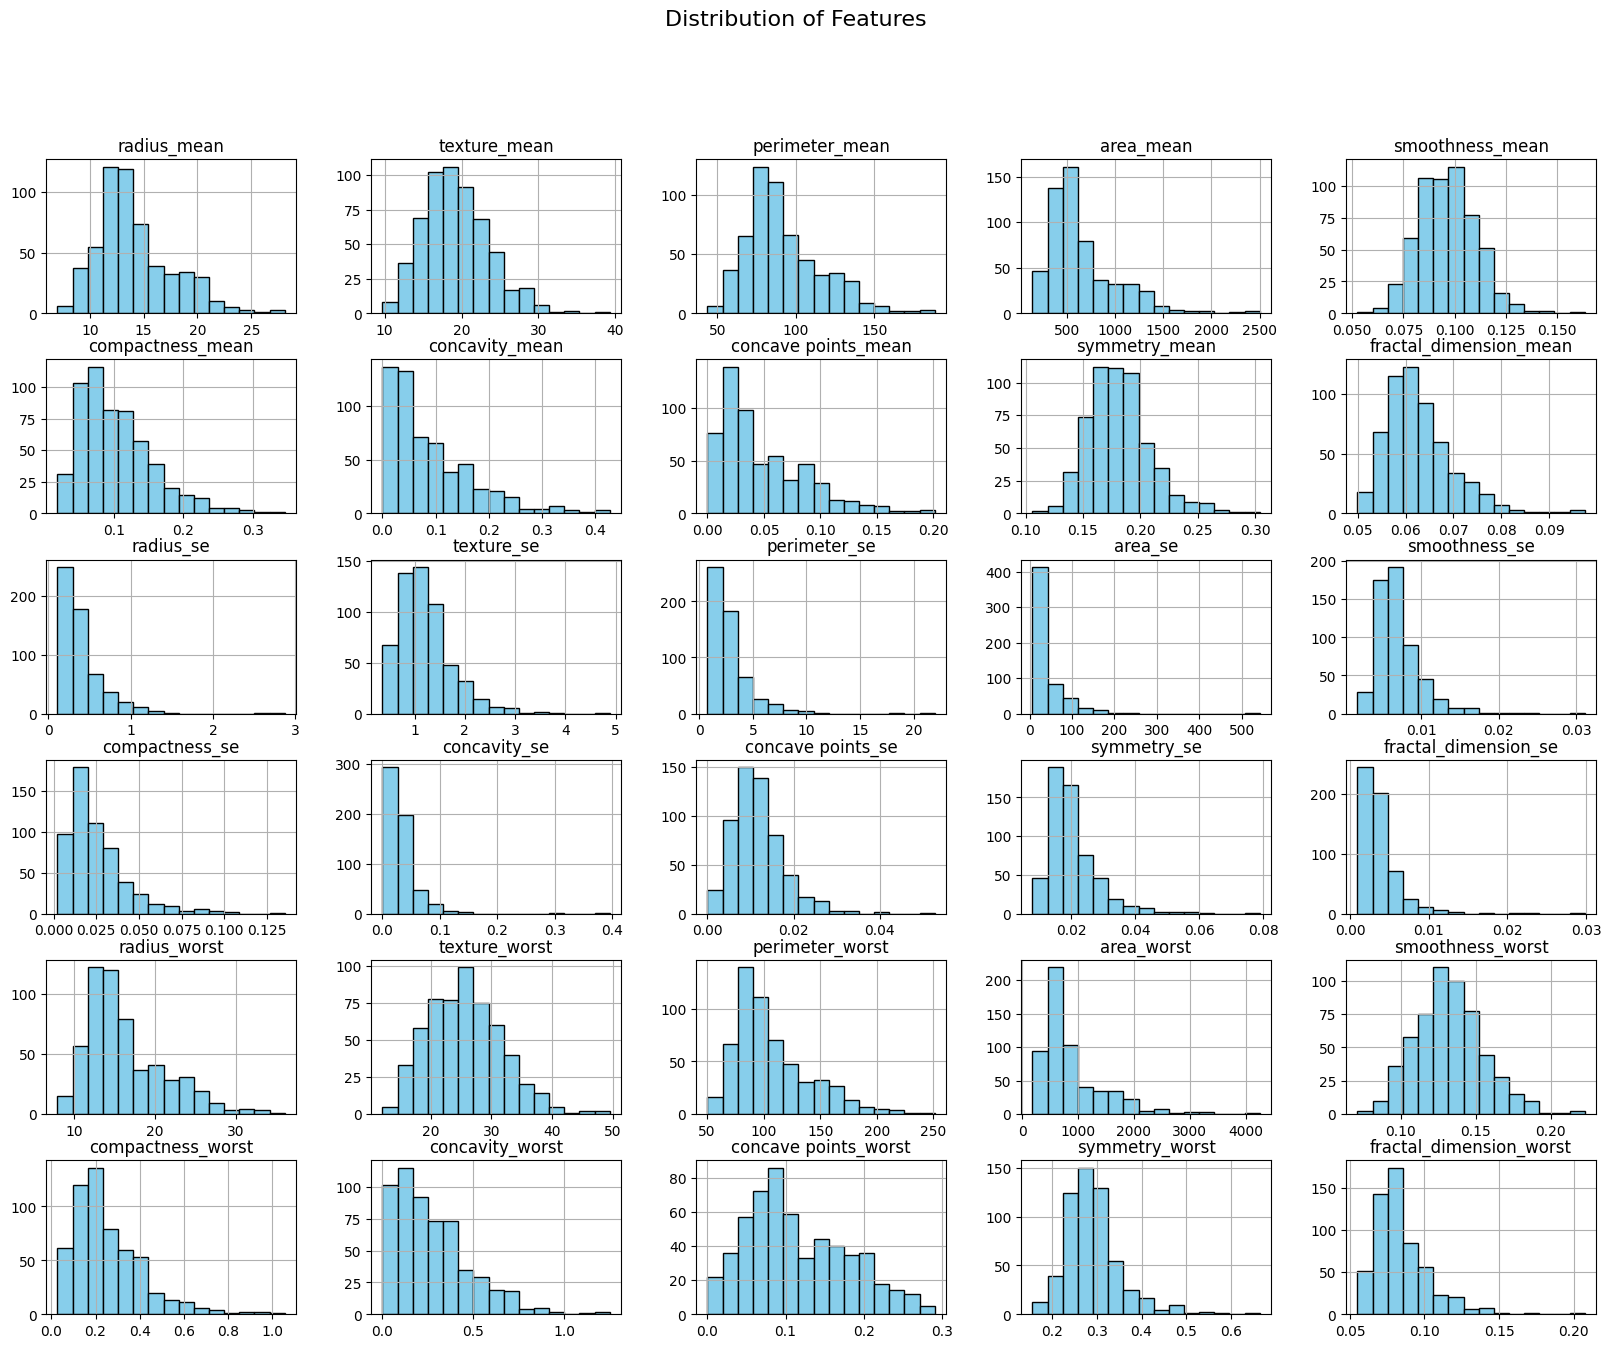

In [7]:
dataset.hist(bins=15, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Features", fontsize=16)
plt.show()